In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from google.colab import drive

drive.mount('/content/drive')

# Load data
file_path = '/content/drive/My Drive/Colab Notebooks/lab-Elec-timeseries__power_dataset_preprocessed.csv'
data = pd.read_csv(file_path, sep=',', parse_dates=['Datetime'], index_col='Datetime')
data = data.sort_index()
data = data.head(5000)  # Take the first 5000 rows

# Ensure data has the necessary columns
if not all(col in data.columns for col in ['Global_active_power', 'Year', 'Quarter', 'Month', 'Day', 'Is_Weekday']):
    raise ValueError("The dataset must contain 'Global_active_power', 'Year', 'Quarter', 'Month', 'Day', and 'Is_Weekday' columns.")

# Normalize data
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)
data_scaled = pd.DataFrame(data_scaled, index=data.index, columns=data.columns)

# Split data
train_size = int(len(data_scaled) * 0.8)
train_data = data_scaled[:train_size]
test_data = data_scaled[train_size:]

# Helper function to prepare data for TimeseriesGenerator
def create_generator(data, target_col, input_cols, lookback):
    generator = TimeseriesGenerator(
        data[input_cols].values,
        data[target_col].values,
        length=lookback,
        batch_size=1
    )
    return generator

# Parameters
lookback = 10

data.head()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,Global_active_power,Year,Quarter,Month,Day,Is_Weekday
Datetime,,,,,,
2006-12-16 17:24:00,4.216,2006,4,12,16,False
2006-12-16 17:25:00,5.360,2006,4,12,16,False
2006-12-16 17:26:00,5.374,2006,4,12,16,False
2006-12-16 17:27:00,5.388,2006,4,12,16,False
2006-12-16 17:28:00,3.666,2006,4,12,16,False


In [4]:
# Univariate Forecasting
univariate_train_gen = create_generator(train_data, 'Global_active_power', ['Global_active_power'], lookback)
univariate_test_gen = create_generator(test_data, 'Global_active_power', ['Global_active_power'], lookback)

# Build and train univariate model
univariate_model = Sequential([
    LSTM(50, activation='relu', input_shape=(lookback, 1)),
    Dense(1)
])
univariate_model.compile(optimizer='adam', loss='mse')
univariate_model.fit(univariate_train_gen, epochs=20, verbose=1)

# Predictions for univariate
univariate_train_pred = univariate_model.predict(univariate_train_gen)
univariate_test_pred = univariate_model.predict(univariate_test_gen)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


3990/3990 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - loss: 0.0091
Epoch 2/20
3990/3990 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - loss: 0.0065
Epoch 3/20
3990/3990 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - loss: 0.0047
Epoch 4/20
3990/3990 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 0.0043
Epoch 5/20
3990/3990 ━━━━━━━━━━━━━━━━━━━━ 19s 2ms/step - loss: 0.0044
Epoch 6/20
3990/3990 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - loss: 0.0045
Epoch 7/20
3990/3990 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - loss: 0.0038
Epoch 8/20
3990/3990 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 0.0036
Epoch 9/20
3990/3990 ━━━━━━━━━━━━━━━━━━━━ 20s 2ms/step - loss: 0.0037
Epoch 10/20
3990/3990 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - loss: 0.0037
Epoch 11/20
3990/3990 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - loss: 0.0035
Epoch 12/20
3990/3990 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - loss: 0.0034
Epoch 13/20
3990/3990 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - loss: 0.0037
Epoch 14/20
3990/3990 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - loss: 0.0035
Epoch 15/20
3990/3990 ━━━━━━━

In [5]:
# Multivariate Forecasting
multivariate_train_gen = create_generator(train_data, 'Global_active_power', ['Global_active_power', 'Year', 'Quarter', 'Month', 'Day', 'Is_Weekday'], lookback)
multivariate_test_gen = create_generator(test_data, 'Global_active_power', ['Global_active_power', 'Year', 'Quarter', 'Month', 'Day', 'Is_Weekday'], lookback)

# Build and train multivariate model
multivariate_model = Sequential([
    LSTM(50, activation='relu', input_shape=(lookback, 6)),
    Dense(1)
])
multivariate_model.compile(optimizer='adam', loss='mse')
multivariate_model.fit(multivariate_train_gen, epochs=20, verbose=1)

# Predictions for multivariate
multivariate_train_pred = multivariate_model.predict(multivariate_train_gen)
multivariate_test_pred = multivariate_model.predict(multivariate_test_gen)

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


3990/3990 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - loss: 0.0104
Epoch 2/20
3990/3990 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - loss: 0.0052
Epoch 3/20
3990/3990 ━━━━━━━━━━━━━━━━━━━━ 18s 2ms/step - loss: 0.0046
Epoch 4/20
3990/3990 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - loss: 0.0039
Epoch 5/20
3990/3990 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - loss: 0.0034
Epoch 6/20
3990/3990 ━━━━━━━━━━━━━━━━━━━━ 20s 2ms/step - loss: 0.0035
Epoch 7/20
3990/3990 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - loss: 0.0035
Epoch 8/20
3990/3990 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 0.0031
Epoch 9/20
3990/3990 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 0.0033
Epoch 10/20
3990/3990 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - loss: 0.0032
Epoch 11/20
3990/3990 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 0.0033
Epoch 12/20
3990/3990 ━━━━━━━━━━━━━━━━━━━━ 20s 2ms/step - loss: 0.0030
Epoch 13/20
3990/3990 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - loss: 0.0029
Epoch 14/20
3990/3990 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - loss: 0.0028
Epoch 15/20
3990/3990 ━━━━━━

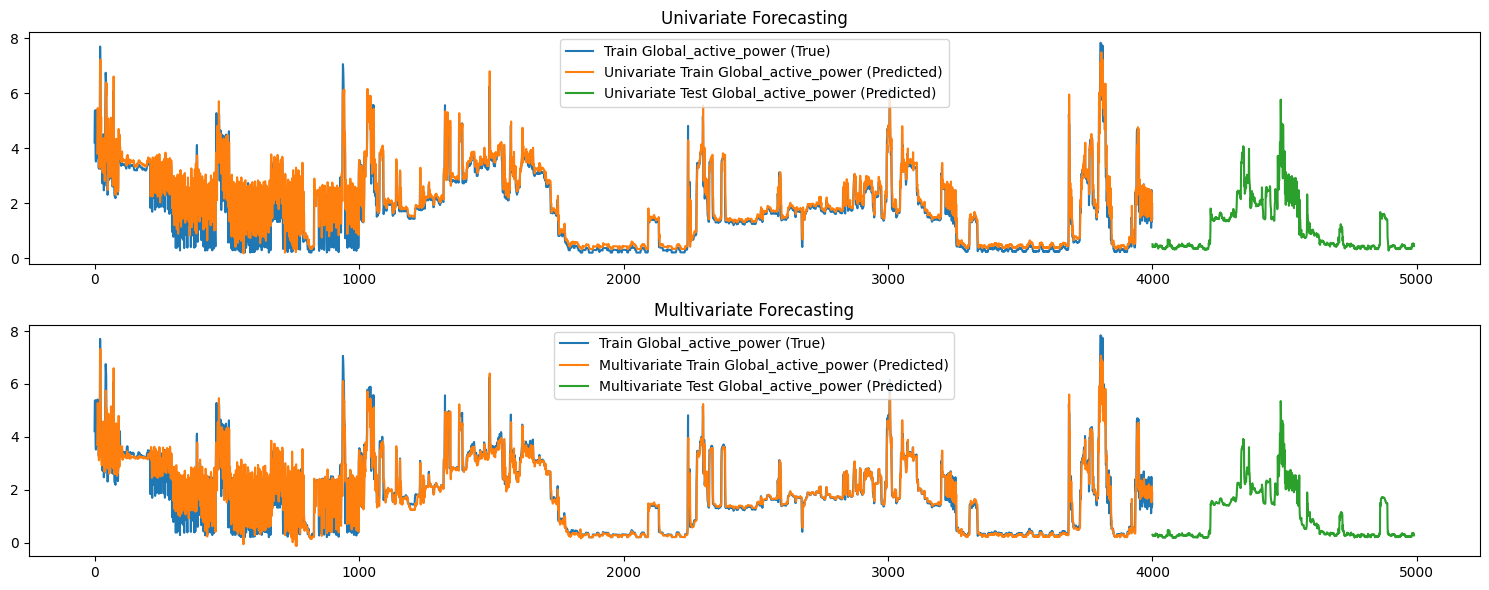

In [6]:
# Rescale predictions
univariate_train_pred = scaler.inverse_transform(
    np.hstack((univariate_train_pred, np.zeros((len(univariate_train_pred), len(data.columns) - 1))))
)[:, 0]
univariate_test_pred = scaler.inverse_transform(
    np.hstack((univariate_test_pred, np.zeros((len(univariate_test_pred), len(data.columns) - 1))))
)[:, 0]

multivariate_train_pred = scaler.inverse_transform(
    np.hstack((multivariate_train_pred, np.zeros((len(multivariate_train_pred), len(data.columns) - 1))))
)[:, 0]
multivariate_test_pred = scaler.inverse_transform(
    np.hstack((multivariate_test_pred, np.zeros((len(multivariate_test_pred), len(data.columns) - 1))))
)[:, 0]

# Rescale original data
train_data = scaler.inverse_transform(train_data)
test_data = scaler.inverse_transform(test_data)

# Plot results
plt.figure(figsize=(15, 6))

plt.subplot(2, 1, 1)
plt.plot(train_data[:, 0], label='Train Global_active_power (True)')
plt.plot(range(lookback, len(univariate_train_pred) + lookback), univariate_train_pred, label='Univariate Train Global_active_power (Predicted)')
plt.plot(range(len(train_data), len(train_data) + len(univariate_test_pred)), univariate_test_pred, label='Univariate Test Global_active_power (Predicted)')
plt.legend()
plt.title('Univariate Forecasting')

plt.subplot(2, 1, 2)
plt.plot(train_data[:, 0], label='Train Global_active_power (True)')
plt.plot(range(lookback, len(multivariate_train_pred) + lookback), multivariate_train_pred, label='Multivariate Train Global_active_power (Predicted)')
plt.plot(range(len(train_data), len(train_data) + len(multivariate_test_pred)), multivariate_test_pred, label='Multivariate Test Global_active_power (Predicted)')
plt.legend()
plt.title('Multivariate Forecasting')

plt.tight_layout()
plt.show()
